In [94]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [8]:
data = pd.read_csv("F:/MLdata/project1_data.csv")

In [3]:
data.head()

,code,date,open,high,low,close,volume,amount,label
0,000001.SZ,20100106,-0.441862,-0.850965,-0.837135,-0.552609,-0.501263,-0.524611,0
1,000002.SZ,20100106,-0.198346,-0.039221,-0.170353,0.213057,-0.513675,-0.512251,0
2,000004.SZ,20100106,0.000000,-0.850965,0.993374,0.166778,0.066573,0.047856,0
3,000005.SZ,20100106,-2.344687,0.433717,0.074610,-0.220380,-0.443835,-0.420490,0
4,000006.SZ,20100106,-0.189523,0.367426,0.473524,0.343659,0.184292,0.167449,0


In [40]:
grouped_data = data.groupby('code')

In [96]:
len(grouped_data)

2480

In [97]:
# 使用过去多少天的数据
sequence_length = 10
# 选择用于训练的特征列
features = ['open', 'high', 'low', 'close', 'volume']
# 遍历每个分组=
X_list = []
y_list = []
x = 0
for code, group_df in grouped_data:
    x += 1
    # 标准化数据
    scaler = MinMaxScaler()
    group_df[features] = scaler.fit_transform(group_df[features])
    # 使用过去多少天的数据
    sequence_length = 10

    # 准备序列数据
    X = []
    for i in range(len(group_df) - sequence_length):
        X.append(group_df[features].values[i:i+sequence_length])

    X = np.array(X)
    y = group_df['label'].values[sequence_length:]

    X_list.append(X)
    y_list.append(y)
    if x > 100:
        break

# 将所有分组得到的X和y拼接起来
X = np.vstack(X_list)
y = np.concatenate(y_list)
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (87717, 10, 5)
y shape: (87717,)


In [102]:
X[1]

array([[0.39801759, 0.35573471, 0.73469797, 0.45158775, 0.29010392],
       [0.31974316, 0.34462057, 0.71997626, 0.32177062, 0.3664558 ],
       [0.33661821, 0.22592339, 0.40582739, 0.19200565, 0.38788219],
       [0.27431085, 0.26376148, 0.18851233, 0.14187637, 0.49904829],
       [0.38304094, 0.2727649 , 0.52515339, 0.23824165, 0.22067143],
       [0.4094069 , 0.46906825, 0.61768324, 0.49540991, 0.36360597],
       [0.36354387, 0.35069433, 0.6674629 , 0.31032907, 0.22904072],
       [0.48616752, 0.5673807 , 0.83374768, 0.61348518, 0.61148889],
       [0.3520725 , 0.46646389, 0.69574651, 0.37578028, 0.219319  ],
       [0.53742474, 0.67906283, 0.70213135, 0.72447898, 0.65415986]])

In [98]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [99]:
len(X_list)

101

In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [103]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EnhancedLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True, dropout_rate=0.5):
        super(EnhancedLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1), hidden_size), # Adjust input size if bidirectional
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )
        self.layer_norm = nn.LayerNorm(hidden_size * (2 if bidirectional else 1))

    def forward(self, x):
        # 初始化LSTM的hidden state和cell state
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)

        # LSTM前向传播
        out, _ = self.lstm(x, (h0, c0))

        # 应用Layer Normalization
        out = self.layer_norm(out[:, -1, :])

        # 经过全连接层网络
        out = self.fc_layers(out)
        return out


In [108]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 假设MyDataset已定义并能正确读取X, y数据
dataset = MyDataset(X, y)

# 创建DataLoader实例
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 定义模型参数
input_size = 5
hidden_size = 8
num_layers = 2
output_size = 2  # 两类，0和1
num_epochs = 4
bidirectional = True  # 使用双向LSTM
dropout_rate = 0.5  # 设置dropout率

In [109]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 实例化模型
model = EnhancedLSTMClassifier(input_size, hidden_size, num_layers, output_size, bidirectional, dropout_rate)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# 用于记录整个训练过程的损失和准确率
epoch_losses = []
epoch_accuracies = []


In [110]:

# 训练模型
for epoch in range(num_epochs):
    total_loss = 0.0
    correct = 0
    total = 0
    for i, (batch_X, batch_y) in enumerate(dataloader):
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

        # 每20个batch报告一次
        if (i + 1) % 20 == 0:
            current_loss = total_loss / (i + 1)
            current_accuracy = correct / total
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch {i+1}, Loss: {current_loss:.4f}, Accuracy: {current_accuracy:.4f}')
    
    # 计算每个epoch的平均损失和准确率
    average_loss = total_loss / len(dataloader)
    accuracy = correct / total
    epoch_losses.append(average_loss)
    epoch_accuracies.append(accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch [1/4], Batch 20, Loss: 0.7097, Accuracy: 0.4750
Epoch [1/4], Batch 40, Loss: 0.7036, Accuracy: 0.4883
Epoch [1/4], Batch 60, Loss: 0.7012, Accuracy: 0.4927
Epoch [1/4], Batch 80, Loss: 0.7012, Accuracy: 0.4945
Epoch [1/4], Batch 100, Loss: 0.7007, Accuracy: 0.4841
Epoch [1/4], Batch 120, Loss: 0.7004, Accuracy: 0.4846
Epoch [1/4], Batch 140, Loss: 0.6996, Accuracy: 0.4853
Epoch [1/4], Batch 160, Loss: 0.6983, Accuracy: 0.4924
Epoch [1/4], Batch 180, Loss: 0.6987, Accuracy: 0.4892
Epoch [1/4], Batch 200, Loss: 0.6986, Accuracy: 0.4859
Epoch [1/4], Batch 220, Loss: 0.6986, Accuracy: 0.4838
Epoch [1/4], Batch 240, Loss: 0.6985, Accuracy: 0.4849
Epoch [1/4], Batch 260, Loss: 0.6981, Accuracy: 0.4877
Epoch [1/4], Batch 280, Loss: 0.6979, Accuracy: 0.4902
Epoch [1/4], Batch 300, Loss: 0.6975, Accuracy: 0.4918
Epoch [1/4], Batch 320, Loss: 0.6974, Accuracy: 0.4918
Epoch [1/4], Batch 340, Loss: 0.6972, Accuracy: 0.4932
Epoch [1/4], Batch 360, Loss: 0.6971, Accuracy: 0.4938
Epoch [1/4], B

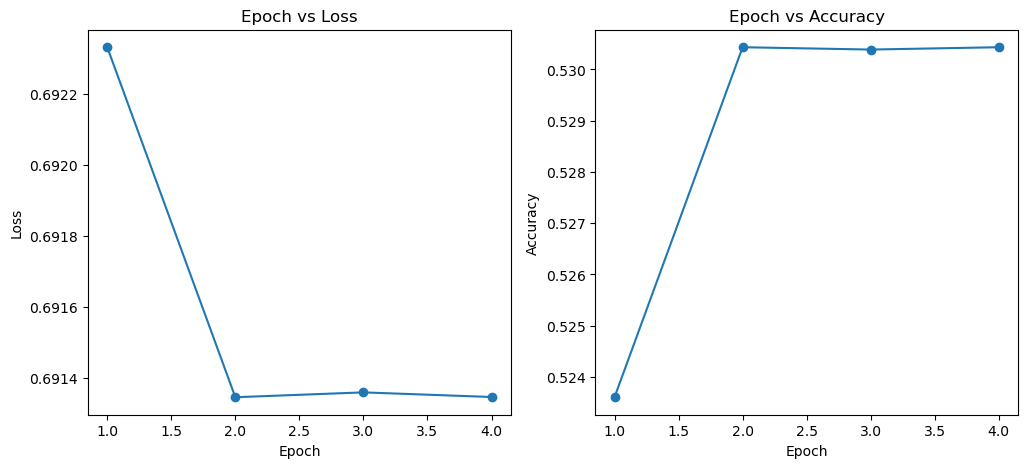

In [112]:
# 绘制损失和准确率图表
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), epoch_losses, marker='o')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), epoch_accuracies, marker='o')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()